## הגדרות ומקדים

In [1]:


import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
from matplotlib import pyplot as plt 
import folium
import fiona
from shapely.geometry import Point


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


## פונקציות

In [3]:
def double_taz_num(df):
    dup_taz_num=df.groupby(['Taz_num']).size().reset_index(name='count').query('count>1').Taz_num.to_list()
    return df.loc[df['Taz_num'].isin(dup_taz_num)]

In [4]:
def make_point(df):
    df_point=df.copy()
    df_point['centroid'] = df_point.representative_point()
    df_point=df_point.set_geometry('centroid')
    df_point=df_point.drop(columns=['geometry'],axis=1)
    return df_point

In [5]:
def up_load_gdb(path,layer_name):
    path='{}'.format(path)
    layer_list=fiona.listlayers(path)
    gpd_layer=gpd.read_file(path, layer=layer_list.index(layer_name))
    return gpd_layer

In [6]:
def up_load_shp(path):
    path='{}'.format(path)
    gpd_layer=gpd.read_file(path)
    return gpd_layer

In [7]:
def unique_id_in_one_taz(df_to_geoode,unique_field,gpd_for_geocode,taz):
    
    code_to_find=list(df_to_geoode[unique_field].unique())

    gpd_for_geocode_to_sum_by_taz=gpd_for_geocode[[unique_field,'geometry']].loc[gpd_for_geocode[unique_field].isin(code_to_find)]

    gpd_for_geocode_to_sum_by_taz=gpd.sjoin(taz[['Taz_num','geometry']],gpd_for_geocode_to_sum_by_taz)

    gpd_for_geocode_in_one_taz=list(gpd_for_geocode_to_sum_by_taz.groupby(unique_field)[['Taz_num']].nunique().query('Taz_num==1').reset_index()[unique_field])

    return gpd_for_geocode_in_one_taz

In [8]:
def up_load_df(folder_path,file_name):
    
    path_df=r'{}\{}.xlsx'.format(folder_path,file_name)
    df=pd.read_excel(path_df)
    df=df.dropna(how='all')

    return df


## העלת שכבות רלוונטים

In [9]:
#העלת משתנים להרצת הקוד
df_inputs_outputs = pd.read_excel('inputs_outputs.xlsx')

software_data_folder_location=df_inputs_outputs['location'][0]

forecast_version_folder_location=df_inputs_outputs['location'][1]


In [10]:
path=r'{}\background_files\student_metro.gdb'.format(software_data_folder_location)
student_gov=up_load_gdb(path,'student_metro_211102')

In [13]:
muni_JTMT=up_load_shp(r'{}\background_files\muni_under_JTMT_ITM.shp'.format(software_data_folder_location))

In [14]:
path=r'{}\background_files'.format(software_data_folder_location)
student_chardi_not_gov=up_load_df(path,'מוסדות חינוך של המתבדלים _מעובד')

In [15]:
student_chardi_not_gov = gpd.GeoDataFrame(
    student_chardi_not_gov, geometry=gpd.points_from_xy(student_chardi_not_gov['x'], student_chardi_not_gov['y'],crs=2039))

In [16]:
student_chardi_not_gov=student_chardi_not_gov[['num_students','geometry']]

In [17]:
path=r'{}\background_files'.format(software_data_folder_location)
student_arab_not_gov=up_load_df(path,'מוסדות_חינוך_270616')

In [18]:
path=r'{}\Intermediates'.format(software_data_folder_location)
taz=up_load_df(path,'taz_with_pop_info')

In [19]:
taz_border=up_load_shp(r'{}\background_files\TAZ_V4_230518_Published.shp'.format(software_data_folder_location))

In [20]:
taz=taz_border.merge(taz,on='Taz_num',how='left')

In [21]:
col=['pop_0',
 'pop_10',
 'pop_15',
 'pop_20',
 'pop_25',
 'pop_30',
 'pop_35',
 'pop_40',
 'pop_45',
 'pop_5',
 'pop_50',
 'pop_55',
 'pop_60',
 'pop_65',
 'pop_70',
 'pop_75up',]

taz['pop_check']=round(taz[col].sum(axis=1)-taz['pop'])

In [22]:
student_yeshiva=up_load_shp(r'{}\background_files\yeshiva.shp'.format(software_data_folder_location))


In [23]:

student_yeshiva=gpd.sjoin(taz[['Taz_num','geometry']],student_yeshiva).pivot_table(index='Taz_num',aggfunc=sum)[[
 'dorms_p00-',
 'dorms_p21-',
 'dorms_p26-',
 'dorms_tota',
 'emp', 'students']]


old_col=list(student_yeshiva)

new_col=['yeshiva_dorms_pop_15', 'yeshiva_dorms_pop_20', 'yeshiva_dorms_pop_25', 'yeshiva_dorms_pop_sum', 'emp_from_Yeshiva_student', 'student_yeshiva']

student_yeshiva.columns=new_col

## מעונות

In [24]:
taz['student_toddlers']=taz['pop_0']/5*3*0.5 # 3 שנתונים עם השתתפות של חמישים אחוז

In [25]:
taz=taz.set_index('Taz_num')

## בית ספר

In [26]:
taz['student_gov']=gpd.sjoin(taz.reset_index(),student_gov).pivot_table(index='Taz_num',aggfunc=sum)[['num_of_students']]

In [27]:
col=['CR_PNIM','Muni_Heb']

In [28]:
muni_JTMT=muni_JTMT[col]

In [29]:
muni_JTMT['CR_PNIM']=muni_JTMT['CR_PNIM'].astype(int)

In [30]:
# Define the directory path
directory_path = r'{}\background_files'.format(software_data_folder_location)

# Load each DataFrame separately
df1 = up_load_df(directory_path, 'cbs_student_2020_by_muni_3')
df2 = up_load_df(directory_path, 'cbs_student_2020_by_muni_1')
df3 = up_load_df(directory_path, 'cbs_student_2020_by_muni_2')

# Concatenate the DataFrames
student_gov_by_muni = pd.concat([df1, df2, df3])

In [31]:
col=[ 'סמל_יישוב','ילדים_בגנים_של_משרד_החינוך_גיל_3_תש_ף_2019_20',
 'ילדים_בגנים_של_משרד_החינוך_גיל_4_תש_ף_2019_20',
 'ילדים_בגנים_של_משרד_החינוך_גיל_5_תש_ף_2019_20',
 'ילדים_בגנים_של_משרד_החינוך_גיל_6_תש_ף_2019_20',
 'תלמידים_בבתי_ספר_יסודיים_תש_ף_2019_20',
 'תלמידים_בבתי_ספר_עליסודיים_תש_ף_2019_20',
 'תלמידים_בחטיבות_ביניים_תש_ף_2019_20',
 'תלמידים_בבתי_ספר_תיכוניים_תש_ף_2019_20']

In [32]:
student_gov_by_muni=student_gov_by_muni[col]

In [33]:
student_gov_by_muni=student_gov_by_muni.merge(muni_JTMT,left_on='סמל_יישוב',right_on='CR_PNIM')

In [34]:
student_gov_by_muni=student_gov_by_muni.drop_duplicates(subset='CR_PNIM',keep='first')

In [35]:
col=[ 'ילדים_בגנים_של_משרד_החינוך_גיל_3_תש_ף_2019_20',
 'ילדים_בגנים_של_משרד_החינוך_גיל_4_תש_ף_2019_20',
 'ילדים_בגנים_של_משרד_החינוך_גיל_5_תש_ף_2019_20',
 'ילדים_בגנים_של_משרד_החינוך_גיל_6_תש_ף_2019_20',
 'תלמידים_בבתי_ספר_יסודיים_תש_ף_2019_20',
 'תלמידים_בחטיבות_ביניים_תש_ף_2019_20',
 'תלמידים_בבתי_ספר_תיכוניים_תש_ף_2019_20']

In [36]:
student_gov_by_muni['student_gov']=student_gov_by_muni[col].sum(axis=1)

In [37]:
col=[ 'CR_PNIM','Muni_Heb','student_gov']
student_gov_by_muni=student_gov_by_muni[col].set_index('CR_PNIM').fillna(0)

In [38]:
taz['CR_PNIM']=taz['CR_PNIM'].astype(int)

In [39]:
jtmt_muni_student_gov=taz.pivot_table(index='CR_PNIM',aggfunc=sum)[['student_gov']].fillna(0)

In [40]:
delta=jtmt_muni_student_gov.merge(student_gov_by_muni,left_index=True,right_index=True,suffixes=('_JTMT','_MUNI'),how='outer').fillna(0)

In [41]:
delta['delta_student']=delta[['student_gov_JTMT','student_gov_MUNI']].max(axis=1)-delta['student_gov_JTMT']

In [42]:
col=['CR_PNIM','delta_student']

In [43]:
taz=taz.reset_index().merge(delta.reset_index()[col],on='CR_PNIM',how='left')

In [44]:
taz['student_demand']=taz['pop_0']/5*2+taz['pop_5']+taz['pop_10']+taz['pop_15']/5*3

In [45]:
taz['student_demand_left']=taz['student_demand']-taz['student_gov']
taz.loc[taz['student_demand_left']<0,'student_demand_left']=0

In [46]:
taz=taz.set_index('CR_PNIM')

In [47]:
taz['student_demand_left_sum_by_muni']=taz.groupby(by='CR_PNIM').sum()[['student_demand_left']]

In [48]:
taz['student_demand_left_pre']=taz['student_demand_left']/taz['student_demand_left_sum_by_muni']

In [49]:
taz['cbs_muni_student_left_by_pre_of_demand_left']=taz['student_demand_left_pre']*taz['delta_student']

## תלמידים בירושלים לפי מגזר

In [50]:
taz['jew']=0
taz.loc[(taz['main_secto']=="Jewish") |( taz['main_secto']=="U_Orthodox"),'jew']=1

In [51]:
taz.query('Muni_Heb=="ירושלים"').groupby(by='jew').sum()[['student_gov','cbs_muni_student_left_by_pre_of_demand_left']]

student_gov  cbs_muni_student_left_by_pre_of_demand_left
jew                                                          
0      58227.000                                    10315.312
1     191795.000                                     9940.688

מקור נתוני חינוך לפי מגזר:https://jerusaleminstitute.org.il/wp-content/uploads/2021/05/shnaton_L0121-1.pdf

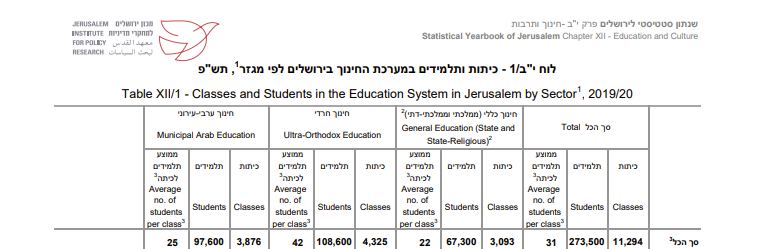

In [52]:
jeru_muni_arab_sum_demand=taz.groupby(by=['CR_PNIM','jew']).sum()[['student_demand']].loc[[3000][0],0].item()

In [53]:
jeru_muni_arab_sum_demand

125858.59175622901

In [54]:
taz=taz.reset_index()

In [55]:
taz.loc[(taz['jew']==0)&( taz['Muni_Heb']=="ירושלים"),'student_demand_pre']=taz['student_demand']/jeru_muni_arab_sum_demand

In [56]:
taz.loc[(taz['jew']==0) &( taz['Muni_Heb']=="ירושלים")]['student_demand_pre'].sum()

0.9999999999999999

In [57]:
taz.loc[(taz['jew']==0) &( taz['Muni_Heb']=="ירושלים"),'cbs_muni_student_left_by_pre_of_demand']=taz['student_demand_pre']*(97600-taz.query('Muni_Heb=="ירושלים"').groupby(by='jew').sum()['student_gov'].loc[0])

In [58]:
taz.loc[ taz['Muni_Heb']=="ירושלים",'cbs_muni_student_left_by_pre_of_demand_left']=0 # בגלל שנתוני מכון ירושלים משמע שבשכת נק' מצאנו יותר תלמידים מאשר המספר הרשמי

In [59]:
taz.query('Muni_Heb=="ירושלים"').groupby(by='jew').sum()[['student_gov','cbs_muni_student_left_by_pre_of_demand_left','cbs_muni_student_left_by_pre_of_demand']]

student_gov  cbs_muni_student_left_by_pre_of_demand_left  \
jew                                                             
0      58227.000                                        0.000   
1     191795.000                                        0.000   

     cbs_muni_student_left_by_pre_of_demand  
jew                                          
0                                 39373.000  
1                                     0.000

In [60]:
col=['student_gov','cbs_muni_student_left_by_pre_of_demand_left','cbs_muni_student_left_by_pre_of_demand','student_toddlers']

In [61]:
taz['student_for_Control']=taz[col].sum(axis=1)

In [62]:
taz.query('Muni_Heb=="ירושלים"').groupby(by='jew').sum()[['student_for_Control']]

student_for_Control
jew                     
0             110952.344
1             215239.387

## תלמידים לא במשרד החינוך

In [63]:
taz=taz.set_index('Taz_num')

In [64]:
taz['student_chardi_not_gov']=gpd.sjoin(taz.reset_index(),student_chardi_not_gov).pivot_table(index='Taz_num',aggfunc=sum)[['num_students']]

In [65]:
student_arab_not_gov=student_arab_not_gov.pivot_table(index='Taz_num',aggfunc=sum)[['num_student']]

In [66]:
taz['student_arab_not_gov']=student_arab_not_gov[['num_student']]

## סך תלמידים

In [67]:
taz=taz.fillna(0)

In [68]:
col=['student_for_Control','student_chardi_not_gov','student_arab_not_gov','student_toddlers']

In [69]:
taz['student']=taz[col].sum(axis=1)

## השכלה גבוהה

In [70]:
uni=up_load_df(r'{}\background_files'.format(software_data_folder_location),'uni_students')

In [71]:
uni = gpd.GeoDataFrame(
    uni, geometry= gpd.GeoSeries.from_wkt(uni['geometry']),crs=4326)

In [72]:
uni=uni.to_crs(crs=2039)

In [73]:
uni=uni.fillna(0)

In [74]:
employ_high_edu=up_load_df(r'{}\background_files'.format(software_data_folder_location),'employ_high_edu')

In [75]:
col=['edu_employ',
 'bussines_employ',
 'comm_employ']

In [76]:
employ_high_edu['emp_uni']=employ_high_edu[col].sum(axis=1)

In [77]:
uni=uni.merge(employ_high_edu,on='ID_camp',how='left')

In [78]:
emp_Education_per_uni_student=0.15

In [79]:
uni.loc[uni['emp_uni'].isna(),'emp_uni']=uni['num_students']*emp_Education_per_uni_student

In [80]:
taz['uni_students']=gpd.sjoin(taz[['geometry']].reset_index(),uni).pivot_table(index='Taz_num',aggfunc=sum)[['num_students']]

In [81]:
taz['emp_from_uni_student']=gpd.sjoin(taz[['geometry']].reset_index(),uni).pivot_table(index='Taz_num',aggfunc=sum)[['emp_uni']]

In [82]:
taz.loc[taz['main_secto']=="Palestinian",'emp_from_uni_student']=0

In [83]:
taz=taz.fillna(0)

## ישיבות

In [84]:
taz['old_student_yeshiva']=0

taz=taz.fillna(0)



In [85]:
taz=taz.join(student_yeshiva).fillna(0)

In [86]:
taz['add_from_old_student_yeshiva']=taz['old_student_yeshiva']-taz['student_yeshiva']

taz.loc[taz['add_from_old_student_yeshiva']<0,'add_from_old_student_yeshiva']=0

taz['kollim_demand']=(taz['pop_20']*0.8+taz['pop_25']*0.65+taz['pop_30']*0.30+taz['pop_35']*0.30+taz['pop_40']*0.30+taz['pop_45']*0.20+taz['pop_50']*0.20+taz['pop_55']*0.20+taz['pop_60']*0.20)*0.5 #הכפלה בחצי בשביל לקבל אוכלוסיית גברים מעורכת

taz.loc[taz['main_secto']!='U_Orthodox','kollim_demand']=0  #אל אף שאנחנו יודעים שיש כוללים באזורים שהם לא מוגדרים כחרדים

taz['add_from_kollim_demand']=0

taz['student_yeshiva_with_add_from_old']=taz['add_from_old_student_yeshiva']+taz['student_yeshiva']



In [87]:
taz.loc[(taz['main_secto']=='U_Orthodox')&(taz['kollim_demand']>taz['student_yeshiva_with_add_from_old']),'add_from_kollim_demand']=taz['kollim_demand']-taz['student_yeshiva_with_add_from_old']

taz['student_yeshiva_and_kollim']=taz['add_from_kollim_demand']+taz['student_yeshiva_with_add_from_old']

## מקדם מועסק חינוך לתלמידים



מקור לנתוני מועסקים בחינוך ירושלים יהודי :https://jerusaleminstitute.org.il/wp-content/uploads/2021/04/shnaton_G0721.pdf

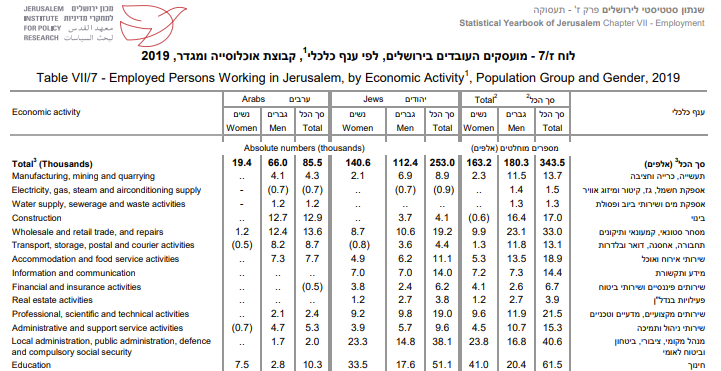

In [88]:
emp_from_uni_student_jeru=taz.query('Muni_Heb=="ירושלים" & jew==1 ')[['emp_from_uni_student']].sum().item()

In [89]:
emp_from_Yeshiva_student_jeru=taz.query('Muni_Heb=="ירושלים" & jew==1 ')[['emp_from_Yeshiva_student']].sum().item()

In [90]:
emp_for_student_jeru_jew=51.1*1000-emp_from_Yeshiva_student_jeru-emp_from_uni_student_jeru

In [91]:
emp_education_per_student=round(taz.query('Muni_Heb=="ירושלים" & jew==1 ')[['student']].sum().item()/emp_for_student_jeru_jew,2) 

In [92]:
emp_education_per_student

6.87

In [93]:
taz['emp_from_student']=taz['student']/emp_education_per_student

In [94]:
taz.loc[taz['main_secto']=="Palestinian",'emp_from_student']=0

In [95]:
taz.query('Muni_Heb=="ירושלים"').groupby(by='jew').sum()[['emp_from_student']]

emp_from_student
jew                  
0           20812.182
1           36281.481

In [96]:
taz['emp_Education']=taz['emp_from_student']+taz['emp_from_Yeshiva_student']+taz['emp_from_uni_student']